# Quantum Reuploading Unit (QRU) Flood Prediction Notebook

This notebook evaluates a pre-trained Quantum Reuploading Unit (QRU) (for now onlu one epoch trained) model that predicts the next-day average water level of the Waikato River from hourly rainfall, flow, and river level data. We will:

1. Load and preprocess the combined hourly dataset.
2. Construct daily samples (features and targets) and split into training/test sets.
3. Load the saved QRU parameters.
4. Define the PennyLane quantum circuit and prediction function.
5. Evaluate the QRU on the test set and record predictions alongside true values and dates.
6. Visualize results, including:
   - Time series of QRU predictions.
   - Real vs. predicted water levels with historical median and 95th percentile.
   - Flood risk scores versus true and predicted water levels.

All code cells are annotated with English explanations.  


In [1]:
# Cell 2: Import required libraries and define constants

import pandas as pd
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Ensure inline plots are shown in the notebook
%matplotlib inline

# Constants
COMBINED_DATA_PATH     = "Data/combined_waikato_weather.csv"
HISTORICAL_DATA_PATH   = "Data/Average_daily_level_compared_to_long-term_record_Waikato.csv"
SAVED_PARAMS_PATH      = "qru_final_params.npy"
TEST_PREDICTIONS_PATH  = "qru_test_predictions_with_dates.csv"

# Quantum and model settings
N_FEATURES       = 3    # rainfall, flow_level, river_level
HOURS_PER_DAY    = 24
NUM_QUBITS       = 3    # one qubit per feature
FEATURE_VECTOR_SIZE = N_FEATURES * HOURS_PER_DAY  # 3 * 24 = 72

## 1. Load and Preprocess the Combined Hourly Dataset

We begin by loading the combined CSV file that contains hourly measurements for:
- `rainfall` (mm)
- `flow_level` (river flow)
- `river_level` (water level)

Each row has a timestamp (`datetime`) and those three features. We will add a `date` column (the calendar day) and compute the next-day average water level (`river_level_daily`) by grouping by `date`.


In [2]:
# Cell 4: Load the combined dataset and compute daily average river level targets

# 1.1 Load the combined hourly dataset
df_hourly = pd.read_csv(
    COMBINED_DATA_PATH,
    parse_dates=["datetime"],
    index_col="datetime"
)

# 1.2 Add a 'date' column (YYYY-MM-DD) to group by day
df_hourly["date"] = df_hourly.index.date

# 1.3 Compute the daily average water level for each calendar day
daily_avg = (
    df_hourly
    .groupby("date")["river_level"]
    .mean()
    .rename("river_level_daily")
)

# 1.4 Preview the hourly data and the daily averages
print("Hourly data sample:")
print(df_hourly.head(5))
print("\nDaily average water level sample:")
print(daily_avg.head(5))

Hourly data sample:
                     wind_speed_avg  wind_speed_max  rainfall  river_level  \
datetime                                                                     
2019-10-22 00:00:00             8.8            13.9       0.0       11.787   
2019-10-22 01:00:00             8.8            12.4       0.0       11.787   
2019-10-22 02:00:00             8.8            11.8       0.0       11.787   
2019-10-22 03:00:00             8.8            12.4       1.4       11.787   
2019-10-22 04:00:00            10.8            13.4       0.0       11.787   

                     flow_level        date  
datetime                                     
2019-10-22 00:00:00     186.463  2019-10-22  
2019-10-22 01:00:00     186.463  2019-10-22  
2019-10-22 02:00:00     186.463  2019-10-22  
2019-10-22 03:00:00     186.463  2019-10-22  
2019-10-22 04:00:00     186.463  2019-10-22  

Daily average water level sample:
date
2019-10-22    11.787
2019-10-23    12.447
2019-10-24    12.436
2019-10-

## 2. Construct Feature and Target Arrays

For each day *t*, we construct:
- **Feature matrix** `X^(t)` of shape `(24, 3)`, containing hourly values for `rainfall`, `flow_level`, and `river_level` on day *t*.
- **Target** `y^(t)` = next-day average water level = `river_level_daily` on day *t+1*.

We exclude any day that does not have exactly 24 hourly rows. We also record the target date (day *t+1*) in `dates_list`, so that we can later match predictions to exact dates for evaluation.


In [3]:
# Cell 6: Build X_list, y_list, and dates_list for all valid days

# 2.1 Sort the list of unique dates present in the hourly data
all_dates = sorted(df_hourly["date"].unique())

X_list = []
y_list = []
dates_list = []

for idx in range(len(all_dates) - 1):
    day_t   = all_dates[idx]
    day_tp1 = all_dates[idx + 1]

    # 2.2 Extract hourly rows for day_t
    df_t = df_hourly[df_hourly["date"] == day_t]
    if df_t.shape[0] != HOURS_PER_DAY:
        # Skip if a full 24 hours are not present
        continue

    # 2.3 Build the (24, 3) feature array for day_t in the order [rainfall, flow_level, river_level]
    features_t = df_t[["rainfall", "flow_level", "river_level"]].values  # shape (24, 3)

    # 2.4 Retrieve the next-day average water level for day_tp1
    if day_tp1 not in daily_avg.index:
        continue
    target_t = daily_avg.loc[day_tp1]

    # 2.5 Append to lists
    X_list.append(features_t)
    y_list.append(target_t)
    dates_list.append(pd.Timestamp(day_tp1))  # Store the date corresponding to y_t

# 2.6 Convert lists to numpy arrays
X_np = np.stack(X_list, axis=0)  # shape = (N, 24, 3)
y_np = np.array(y_list)         # shape = (N,)
dates_np = np.array(dates_list, dtype="datetime64[ns]")  # shape = (N,)

print(f"Total days used: {len(X_np)}")
print("Example shapes -> X_np:", X_np.shape, "y_np:", y_np.shape)
print("Example dates_list:", dates_np[:5])

Total days used: 2034
Example shapes -> X_np: (2034, 24, 3) y_np: (2034,)
Example dates_list: ['2019-10-23T00:00:00.000000000' '2019-10-24T00:00:00.000000000'
 '2019-10-25T00:00:00.000000000' '2019-10-26T00:00:00.000000000'
 '2019-10-27T00:00:00.000000000']


### 2.1 Normalize Features

We normalize each feature (rainfall, flow_level, river_level) into the range [0, 2π] so that they can be encoded into RY rotations on the quantum circuit. Specifically, for each feature *f*, compute:

\[
x_{\text{norm}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}} \times 2\pi,
\]

where \(x_{\min}\) and \(x_{\max}\) are the global minimum and maximum of that feature across all days and hours.


In [4]:
# Cell 8: Normalize all features into [0, 2π]

# 2.7 Flatten over all days and hours to compute global min/max per feature
flattened = X_np.reshape(-1, N_FEATURES)  # shape = (N * 24, 3)
mins = flattened.min(axis=0)              # (3,)
maxs = flattened.max(axis=0)              # (3,)

def normalize_day(arr_24x3, mins, maxs):
    """
    arr_24x3 : np.ndarray of shape (24, 3)
    Returns: (24,3) normalized in [0, 2π] feature-wise
    """
    scaled = (arr_24x3 - mins) / (maxs - mins)  # now in [0,1]
    return scaled * 2 * np.pi  # now in [0, 2π]

# 2.8 Apply normalize_day to every day
X_norm = np.stack([normalize_day(X_np[i], mins, maxs) for i in range(X_np.shape[0])], axis=0)
# X_norm.shape = (N, 24, 3)

# 2.9 Reshape into (N, 72) = (N, 3*24), stacking features by qubit
#     Order: first 24 rainfall, next 24 flow, last 24 river
X_norm_T = X_norm.transpose(0, 2, 1)  # shape = (N, 3, 24)
X_flat_qru = X_norm_T.reshape(X_norm_T.shape[0], -1)  # shape = (N, 72)

print("Normalized feature vector shape:", X_flat_qru.shape)

Normalized feature vector shape: (2034, 72)


## 3. Split into Training and Test Sets

We split the data into an 80% training set and a 20% test set, using a fixed random seed (`random_state=42`) for reproducibility. We also split the `dates_np` array in the same way, so that `dates_test` precisely aligns with `X_test` and `y_test`.


In [5]:
# Cell 10: Perform train-test split and keep dates aligned

X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X_flat_qru, y_np, dates_np, test_size=0.20, random_state=42
)

print("Training set size:", X_train.shape[0])
print("Test set size:   ", X_test.shape[0])
print("Example test dates:", dates_test[:5])

Training set size: 1627
Test set size:    407
Example test dates: ['2021-06-25T00:00:00.000000000' '2020-02-11T00:00:00.000000000'
 '2023-01-20T00:00:00.000000000' '2023-12-11T00:00:00.000000000'
 '2021-12-02T00:00:00.000000000']


## 4. Load Pre-trained QRU Parameters

We have previously trained the QRU and saved its learned parameters into a NumPy file `qru_final_params.npy`. This array contains, in order:
1. **72 angles** (for the `RZ` gates in the circuit)  
2. **3 linear coefficients** \(a_1, a_2, a_3\) for combining the three measured ⟨Z⟩ values  
3. **1 bias** \(b\)

We will load this file and separate these parameters for use in prediction.


In [6]:
# Cell 12: Load pre-trained QRU parameters from file

all_params = np.load(SAVED_PARAMS_PATH)  # shape = (72 + 3 + 1,) = (76,)

# Separate into circuit weights and linear layer coefficients
weights_final = all_params[:FEATURE_VECTOR_SIZE]                     # (72,)
a_final       = all_params[FEATURE_VECTOR_SIZE:FEATURE_VECTOR_SIZE+NUM_QUBITS]  # (3,)
b_final       = all_params[-1]                                       # scalar

print("Loaded QRU parameters:")
print("  - RZ angles (first 5):", weights_final[:5])
print("  - Linear coefficients (a1,a2,a3):", a_final)
print("  - Bias b:", b_final)


Loaded QRU parameters:
  - RZ angles (first 5): [3.43618433 3.9733453  3.50706849 2.7284131  2.30734332]
  - Linear coefficients (a1,a2,a3): [ 3.52081753  4.19806521 -2.71932735]
  - Bias b: 3.205586435222617


## 5. Define the QRU PennyLane QNode and Prediction Function

We create a single-qubit-per-feature circuit with **3 qubits**. Each qubit is re-uploaded with its corresponding feature’s hourly values over 24 layers:
- Qubit 0 encodes the normalized `rainfall` sequence.
- Qubit 1 encodes the normalized `flow_level` sequence.
- Qubit 2 encodes the normalized `river_level` sequence.

At layer *k* (hour *k*), we perform:

RY(x_normalized[k]) → RZ(θ[k]) 

on each qubit. After all 24 layers, we measure ⟨Z⟩ on each qubit. The three resulting expectation values are combined by a linear function

ŷ = a₁·⟨Z₀⟩ + a₂·⟨Z₁⟩ + a₃·⟨Z₂⟩ + b

to produce the final predicted water level for the next day.


In [7]:
# Cell 14: Define the PennyLane QNode and the prediction function

dev = qml.device("default.qubit", wires=NUM_QUBITS)

@qml.qnode(dev, interface="autograd")
def qru_circuit(x_input, weights):
    """
    x_input  : numpy array of shape (72,), values in [0, 2π]
    weights  : numpy array of shape (72,), RZ angles to be applied
    Returns : list of 3 expectation values ⟨Z⟩, one per qubit
    """
    for k in range(HOURS_PER_DAY):
        # Indices for each feature at hour k
        idx_rain  = k
        idx_flow  = HOURS_PER_DAY + k
        idx_river = 2 * HOURS_PER_DAY + k

        # Encode rainfall on qubit 0
        qml.RY(x_input[idx_rain], wires=0)
        qml.RZ(weights[idx_rain],   wires=0)

        # Encode flow_level on qubit 1
        qml.RY(x_input[idx_flow], wires=1)
        qml.RZ(weights[idx_flow], wires=1)

        # Encode river_level on qubit 2
        qml.RY(x_input[idx_river], wires=2)
        qml.RZ(weights[idx_river], wires=2)

    return [qml.expval(qml.PauliZ(i)) for i in range(NUM_QUBITS)]


def predict_quantum(x, weights, a, b):
    """
    Given:
      - x       : feature vector shape (72,) normalized
      - weights : RZ angles shape (72,)
      - a       : linear coefficients shape (3,)
      - b       : bias (scalar)
    Returns the predicted next-day water level (scalar).
    """
    z_vals = qru_circuit(x, weights)  # three ⟨Z⟩ values
    z_arr = np.stack(z_vals)          # convert to array shape (3,)
    return np.dot(a, z_arr) + b       # linear combination → scalar


## 6. Evaluate QRU on the Test Set

Using the pre-trained parameters, we compute predictions on the test set:
1. Compute `y_pred` for every `X_test`.
2. Measure the Mean Squared Error (MSE) between `y_pred` and `y_test`.
3. Create a DataFrame containing `date`, `y_true`, and `y_pred` for each test sample.
4. Save this DataFrame to CSV for later analysis.


In [8]:
# Cell 16: Evaluate on test set and save results with dates

# 6.1 Compute predictions y_pred on the test set
y_pred = np.array([
    predict_quantum(X_test[i], weights_final, a_final, b_final)
    for i in range(X_test.shape[0])
])

# 6.2 Compute test MSE
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test set MSE = {test_mse:.4f}")

# 6.3 Build a DataFrame with date, y_true, y_pred
df_test_results = pd.DataFrame({
    "date":   pd.to_datetime(dates_test),
    "y_true": y_test,
    "y_pred": y_pred
})

# 6.4 Save to CSV
df_test_results.to_csv(TEST_PREDICTIONS_PATH, index=False)
print(f"Saved test predictions with dates to '{TEST_PREDICTIONS_PATH}'")


Test set MSE = 1.2249
Saved test predictions with dates to 'qru_test_predictions_with_dates.csv'


## 7. Load Historical Median and 95th Percentile Data

To compute flood risk, we need the historical daily median and 95th percentile water levels. We load the CSV and set up a `compute_flood_risk()` function that:
- Looks up the `median` and `95per` values for a given date.
- Returns a risk score between 0 and 1 according to:
  - If `predicted_level ≤ median`: 
    risk = 0.5 × (predicted_level / median)
  - If `predicted_level ≥ 95per`: 
    risk = 0.85
  - Else (median < predicted_level < 95per): 
    risk = 0.5 + ((predicted_level − median)/(95per − median)) × 0.35


In [9]:
# Cell 18: Load historical median & 95th percentile, define flood risk function

# 7.1 Load historical data
df_hist = pd.read_csv(
    HISTORICAL_DATA_PATH,
    skiprows=2,
    skipfooter=4,
    engine="python",
    parse_dates=["date"]
)
df_hist.columns = [
    "dateTime",  # timestamp at midday (not used further)
    "date",      # date in YYYY-MM-DD format
    "median",
    "min",
    "max",
    "5per",
    "95per",
    "mean"
]
df_hist = df_hist.set_index("date").sort_index()
df_hist[["median", "95per"]] = df_hist[["median", "95per"]].astype(float)

def compute_flood_risk(pred_date, predicted_level):
    """
    pred_date        : datetime-like or 'YYYY-MM-DD' string
    predicted_level  : float (predicted next-day water level in meters)

    Returns a float ∈ [0,1] indicating flood risk:
      - If predicted_level <= median: 
          risk = 0.5 * (predicted_level / median)
      - If predicted_level >= 95per: 
          risk = 0.85
      - Otherwise: 
          risk = 0.5 + ((predicted_level - median)/(95per - median)) * 0.35
    """
    # Convert string to Timestamp if needed
    if isinstance(pred_date, str):
        ts = pd.to_datetime(pred_date)
    elif isinstance(pred_date, pd.Timestamp):
        ts = pred_date
    else:
        ts = pd.to_datetime(pred_date)

    if ts not in df_hist.index:
        raise KeyError(f"The date {ts.date()} is not in the historical dataset.")

    med_val = df_hist.loc[ts, "median"]
    p95_val = df_hist.loc[ts, "95per"]

    if predicted_level <= med_val:
        return 0.0 if med_val == 0 else 0.5 * (predicted_level / med_val)
    if predicted_level >= p95_val:
        return 0.85
    # Linear interpolation between 0.5 and 0.85
    return 0.5 + ((predicted_level - med_val) / (p95_val - med_val)) * 0.35


## 8. Visualize Test Results

1. **Time Series of QRU Predictions**  
   Plot QRU-predicted water levels (`y_pred`) against actual calendar dates (`dates_test`).

2. **Real vs Predicted with Historical Thresholds**  
   Scatter each test date’s true and predicted water levels, and overlay the historical daily `median` and `95per` curves for those dates.

3. **Flood Risk vs. True Water Level**  
   Compute the flood risk for each test sample using the *true* water level, then plot risk vs. actual water level.

4. **Flood Risk vs. Predicted Water Level**  
   Compute the flood risk for each test sample using the *predicted* water level, then plot risk vs. predicted water level.


Test MSE on last 14 days: 2.7767


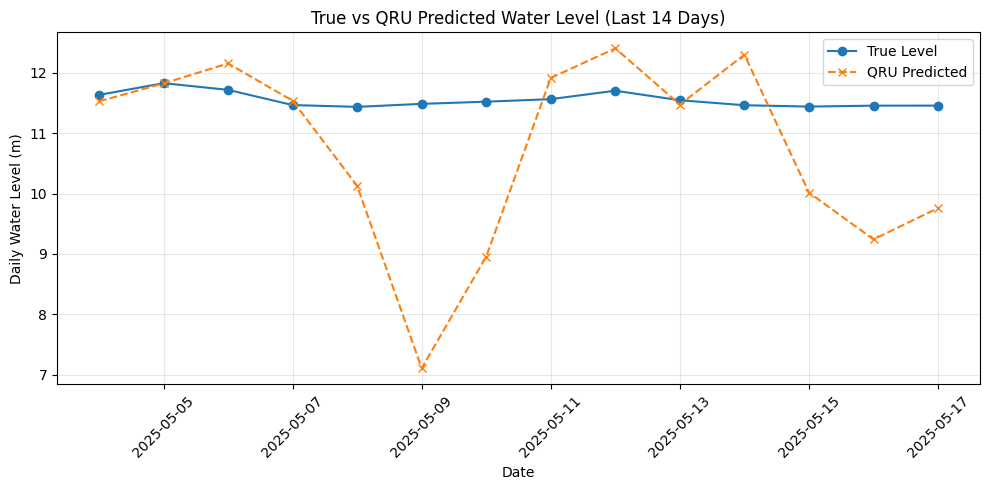

In [14]:
# ---------------------------------------------------------
# Evaluate Pre-trained QRU on the Last 14 Days of Data
# ---------------------------------------------------------

import pandas as pd
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 1) Load the combined hourly dataset
df_hourly = pd.read_csv(
    "Data/combined_waikato_weather.csv",
    parse_dates=["datetime"],
    index_col="datetime"
)

# 2) Add a 'date' column (calendar day without time) for grouping
df_hourly["date"] = df_hourly.index.date

# 3) Compute daily average of river_level for each date
daily_avg = df_hourly.groupby("date")["river_level"].mean().rename("river_level_daily")

# 4) Build X_np, y_np, and dates_np arrays for every valid day
all_dates = sorted(df_hourly["date"].unique())
X_list = []
y_list = []
dates_list = []

for idx in range(len(all_dates) - 1):
    day_t   = all_dates[idx]
    day_tp1 = all_dates[idx + 1]

    df_t = df_hourly[df_hourly["date"] == day_t]
    # Only proceed if exactly 24 hourly records exist for day_t
    if df_t.shape[0] != 24:
        continue

    # Extract features (rainfall, flow_level, river_level) as a (24, 3) array
    arr_t = df_t[["rainfall", "flow_level", "river_level"]].values

    # The target is the average river_level on day_tp1
    if day_tp1 not in daily_avg.index:
        continue
    y_t = daily_avg.loc[day_tp1]

    X_list.append(arr_t)
    y_list.append(y_t)
    dates_list.append(pd.Timestamp(day_tp1))

X_np     = np.stack(X_list, axis=0)                 # shape = (N, 24, 3)
y_np     = np.array(y_list)                         # shape = (N,)
dates_np = np.array(dates_list, dtype="datetime64") # shape = (N,)

# 5) Identify the last 14 days for testing (chronologically)
sort_idx      = np.argsort(dates_np)
dates_sorted  = dates_np[sort_idx]
X_sorted      = X_np[sort_idx]
y_sorted      = y_np[sort_idx]

# Last 14 days are our test set
num_test_days = 14
X_test_days   = X_sorted[-num_test_days:]            # shape = (14, 24, 3)
y_test_days   = y_sorted[-num_test_days:]            # shape = (14,)
dates_test    = dates_sorted[-num_test_days:]        # shape = (14,)

# 6) Normalize the features for these last 14 days
#    We need global min/max for each feature computed over the entire dataset.
flattened_all = X_np.reshape(-1, 3)  # shape = (N*24, 3)
mins = flattened_all.min(axis=0)     # (3,)
maxs = flattened_all.max(axis=0)     # (3,)

def normalize_day(arr_24x3, mins, maxs):
    """
    Normalize a (24,3) array feature-wise into [0, 2π].
    """
    scaled = (arr_24x3 - mins) / (maxs - mins)  # now in [0,1]
    return scaled * 2 * np.pi                   # now in [0,2π]

X_test_norm = np.stack([normalize_day(X_test_days[i], mins, maxs) for i in range(num_test_days)], axis=0)
# X_test_norm.shape = (14, 24, 3)

# 7) Reshape each (24,3) into a flat (72,) vector for the QRU
X_test_flat = X_test_norm.transpose(0, 2, 1).reshape(num_test_days, -1)  # shape = (14, 72)

# 8) Load the saved QRU parameters from file
all_params     = np.load("qru_final_params.npy")  # length = 72 + 3 + 1 = 76
FEATURE_SIZE   = X_test_flat.shape[1]             # should be 72
NUM_QUBITS     = 3

weights_final = all_params[:FEATURE_SIZE]                                 # (72,)
a_final       = all_params[FEATURE_SIZE:FEATURE_SIZE + NUM_QUBITS]       # (3,)
b_final       = all_params[-1]                                            # scalar

# 9) Define the QRU QNode and prediction function
dev = qml.device("default.qubit", wires=NUM_QUBITS)

@qml.qnode(dev, interface="autograd")
def qru_circuit(x_input, weights):
    for k in range(24):
        idx_rain  = k
        idx_flow  = 24 + k
        idx_river = 48 + k

        # Qubit 0: rainfall
        qml.RY(x_input[idx_rain], wires=0)
        qml.RZ(weights[idx_rain],   wires=0)

        # Qubit 1: flow level
        qml.RY(x_input[idx_flow], wires=1)
        qml.RZ(weights[idx_flow], wires=1)

        # Qubit 2: river level
        qml.RY(x_input[idx_river], wires=2)
        qml.RZ(weights[idx_river], wires=2)

    return [qml.expval(qml.PauliZ(i)) for i in range(NUM_QUBITS)]

def predict_quantum(x, weights, a, b):
    """
    Compute predicted next-day water level given:
    - x       : normalized feature vector of shape (72,)
    - weights : RZ angles, shape (72,)
    - a       : linear coefficients (3,)
    - b       : bias (scalar)
    """
    z_vals = qru_circuit(x, weights)  # list of 3 ⟨Z⟩ values
    z_arr  = np.stack(z_vals)         # shape = (3,)
    return np.dot(a, z_arr) + b       # scalar prediction

# 10) Compute QRU predictions for the last 14 days
y_pred_days = np.array([
    predict_quantum(X_test_flat[i], weights_final, a_final, b_final)
    for i in range(num_test_days)
])

# 11) Compute MSE on the 14-day test set
mse_14days = mean_squared_error(y_test_days, y_pred_days)
print(f"Test MSE on last 14 days: {mse_14days:.4f}")

# 12) Build a DataFrame with date, true, and predicted values
df_last14 = pd.DataFrame({
    "date":        pd.to_datetime(dates_test),
    "true_level":  y_test_days,
    "predicted":   y_pred_days
})

# 13) Plot True vs Predicted for the last 14 days
plt.figure(figsize=(10, 5))
plt.plot(df_last14["date"], df_last14["true_level"],
         marker="o", linestyle="-", color="tab:blue", label="True Level")
plt.plot(df_last14["date"], df_last14["predicted"],
         marker="x", linestyle="--", color="tab:orange", label="QRU Predicted")
plt.xlabel("Date")
plt.ylabel("Daily Water Level (m)")
plt.title("True vs QRU Predicted Water Level (Last 14 Days)")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## 10. Plot Historical Daily Median, 95th Percentile, Mean & QRU Predictions for 2025

In this cell, we visualize:
- **Historical daily statistics** (median, 95th percentile, and mean) of Waikato River levels, computed across all data since 2019.  
- **QRU predictions** of next-day water level for each day in 2025.  

Note that the CSV `"Average_daily_level_compared_to_long-term_record_Waikato.csv"` provides, for each calendar date since 2019, the long‐term historical median, 95th percentile, and mean of that day’s water level. We will:
1. Filter those historical daily values to the year 2025.
2. Recompute QRU predictions for every day in 2025.
3. Plot the three historical curves (median, 95th percentile, mean) and overlay the QRU-predicted points.


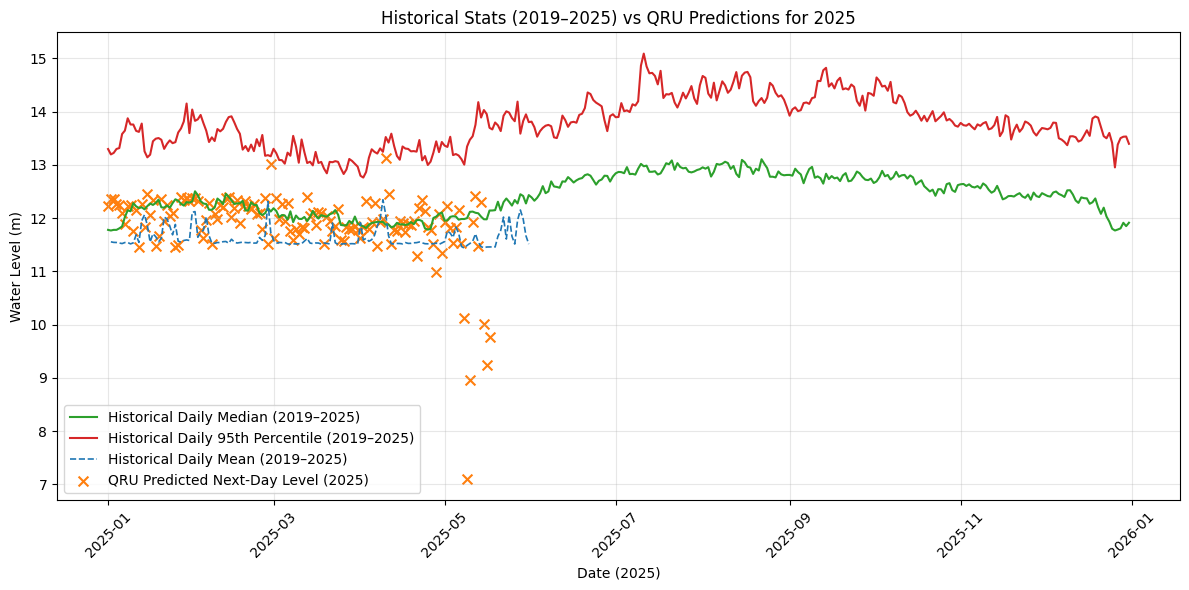

In [16]:
# Cell 10: Plot Historical Median, 95th Percentile, Mean & QRU Predictions for 2025

import pandas as pd
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

# 10.1 Load historical daily statistics (median, 95per, mean) from 2019 onward
df_hist = pd.read_csv(
    "Data/Average_daily_level_compared_to_long-term_record_Waikato.csv",
    skiprows=2,
    skipfooter=4,
    engine="python",
    parse_dates=["date"]
)
df_hist.columns = [
    "dateTime",   # timestamp at midday (unused)
    "date",       # calendar date (YYYY-MM-DD)
    "median",     # historical daily median (2019 onward)
    "min",        # historical daily minimum
    "max",        # historical daily maximum
    "5per",       # historical daily 5th percentile
    "95per",      # historical daily 95th percentile
    "mean"        # historical daily mean (2019 onward)
]
df_hist = df_hist.set_index("date").sort_index()
# Ensure numeric columns
df_hist[["median", "95per", "mean"]] = df_hist[["median", "95per", "mean"]].astype(float)

# 10.2 Filter the historical stats to calendar year 2025
start_2025   = pd.Timestamp("2025-01-01")
end_2025     = pd.Timestamp("2025-12-31")
df_hist_2025 = df_hist.loc[start_2025:end_2025, ["median", "95per", "mean"]]

# 10.3 Reconstruct feature samples for every valid day (as in Cells 4–6)
df_hourly = pd.read_csv(
    "Data/combined_waikato_weather.csv",
    parse_dates=["datetime"],
    index_col="datetime"
)
df_hourly["date"] = df_hourly.index.date
daily_avg_full = df_hourly.groupby("date")["river_level"].mean().rename("river_level_daily")

all_dates = sorted(df_hourly["date"].unique())
X_list, dates_list = [], []
for i in range(len(all_dates) - 1):
    day_t   = all_dates[i]
    day_tp1 = all_dates[i + 1]

    df_t = df_hourly[df_hourly["date"] == day_t]
    if df_t.shape[0] != 24:
        continue

    arr_t = df_t[["rainfall", "flow_level", "river_level"]].values
    if day_tp1 not in daily_avg_full.index:
        continue

    X_list.append(arr_t)
    dates_list.append(pd.Timestamp(day_tp1))

X_np     = np.stack(X_list, axis=0)                         # shape = (N, 24, 3)
dates_np = np.array(dates_list, dtype="datetime64[ns]")     # shape = (N,)

# 10.4 Normalize all features using global min/max (2019 onward)
flattened_all = X_np.reshape(-1, 3)
mins = flattened_all.min(axis=0)
maxs = flattened_all.max(axis=0)

def normalize_day(arr_24x3, mins, maxs):
    scaled = (arr_24x3 - mins) / (maxs - mins)  # in [0,1]
    return scaled * 2 * np.pi                   # in [0, 2π]

X_norm = np.stack([normalize_day(X_np[i], mins, maxs) for i in range(X_np.shape[0])], axis=0)
X_flat_all = X_norm.transpose(0, 2, 1).reshape(X_norm.shape[0], -1)  # shape = (N, 72)

# 10.5 Select only the samples whose date is in 2025
mask_2025       = (dates_np >= np.datetime64("2025-01-01")) & (dates_np <= np.datetime64("2025-12-31"))
X_2025_features = X_flat_all[mask_2025]       # shape = (M, 72)
dates_2025      = dates_np[mask_2025]          # shape = (M,)

# 10.6 Load pre-trained QRU parameters
params_all    = np.load("qru_final_params.npy")
FEATURE_SIZE  = X_2025_features.shape[1]  # should be 72
NUM_QUBITS    = 3

weights_final = params_all[:FEATURE_SIZE]                                
a_final       = params_all[FEATURE_SIZE:FEATURE_SIZE + NUM_QUBITS]       
b_final       = params_all[-1]                                            

# 10.7 Define the QRU QNode and prediction function
dev = qml.device("default.qubit", wires=NUM_QUBITS)

@qml.qnode(dev, interface="autograd")
def qru_circuit(x_input, weights):
    for k in range(24):
        idx_rain  = k
        idx_flow  = 24 + k
        idx_river = 48 + k

        # Qubit 0: rainfall
        qml.RY(x_input[idx_rain], wires=0)
        qml.RZ(weights[idx_rain],   wires=0)

        # Qubit 1: flow_level
        qml.RY(x_input[idx_flow], wires=1)
        qml.RZ(weights[idx_flow], wires=1)

        # Qubit 2: river_level
        qml.RY(x_input[idx_river], wires=2)
        qml.RZ(weights[idx_river], wires=2)

    return [qml.expval(qml.PauliZ(i)) for i in range(NUM_QUBITS)]

def predict_quantum(x, weights, a, b):
    z_vals = qru_circuit(x, weights)    # list of 3 ⟨Z⟩ values
    z_arr  = np.stack(z_vals)           # shape = (3,)
    return np.dot(a, z_arr) + b         # scalar next-day prediction

# 10.8 Compute QRU predictions for each 2025 sample
y_pred_2025 = np.array([
    predict_quantum(X_2025_features[i], weights_final, a_final, b_final)
    for i in range(X_2025_features.shape[0])
])

# 10.9 Build a DataFrame of QRU predictions with dates and merge with historical stats
df_pred_2025 = pd.DataFrame({
    "date":      pd.to_datetime(dates_2025),
    "qru_pred":  y_pred_2025
}).set_index("date").sort_index()

# Join historical median/95per/mean (index = date) with QRU predictions
df_plot_2025 = df_hist_2025.join(df_pred_2025, how="left")

# 10.10 Plot all four curves: median, 95per, mean, and QRU predictions
plt.figure(figsize=(12, 6))

# Historical daily median (2019 onward)
plt.plot(
    df_plot_2025.index, 
    df_plot_2025["median"], 
    label="Historical Daily Median (2019–2025)", 
    color="tab:green", 
    linewidth=1.5
)
# Historical daily 95th percentile (2019 onward)
plt.plot(
    df_plot_2025.index, 
    df_plot_2025["95per"], 
    label="Historical Daily 95th Percentile (2019–2025)", 
    color="tab:red", 
    linewidth=1.5
)
# Historical daily mean (2019 onward)
plt.plot(
    df_plot_2025.index, 
    df_plot_2025["mean"], 
    label="Historical Daily Mean (2019–2025)", 
    color="tab:blue", 
    linestyle="--", 
    linewidth=1.2
)
# QRU predictions for 2025
plt.scatter(
    df_plot_2025.index, 
    df_plot_2025["qru_pred"], 
    label="QRU Predicted Next-Day Level (2025)", 
    color="tab:orange", 
    marker="x", 
    s=50
)

plt.xlabel("Date (2025)")
plt.ylabel("Water Level (m)")
plt.title("Historical Stats (2019–2025) vs QRU Predictions for 2025")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


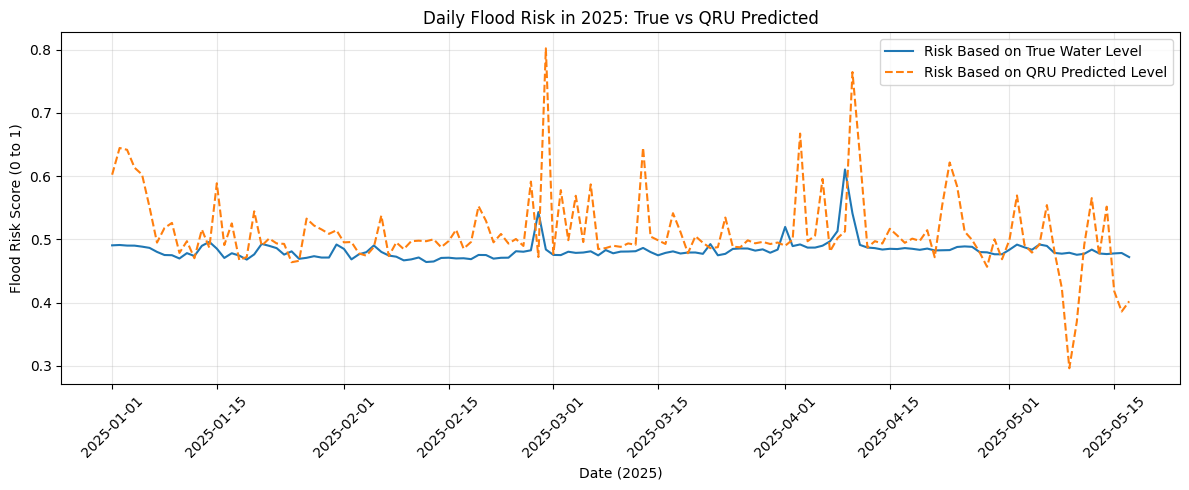

In [20]:
# Cell: Compute Flood Risk for 2025 and Plot Risk vs Date

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load historical stats (median, 95per) from 2019 onward
df_hist = pd.read_csv(
    "Data/Average_daily_level_compared_to_long-term_record_Waikato.csv",
    skiprows=2,
    skipfooter=4,
    engine="python",
    parse_dates=["date"]
)
df_hist.columns = [
    "dateTime", "date", "median", "min", "max", "5per", "95per", "mean"
]
df_hist = df_hist.set_index("date").sort_index()
df_hist[["median", "95per"]] = df_hist[["median", "95per"]].astype(float)

# 2) Define compute_flood_risk function (uses df_hist)
def compute_flood_risk(pred_date, predicted_level):
    """
    pred_date       : pd.Timestamp or 'YYYY-MM-DD' string
    predicted_level : float
    
    Returns a risk score in [0,1] based on historical median and 95th percentile.
    """
    if isinstance(pred_date, str):
        ts = pd.to_datetime(pred_date)
    else:
        ts = pd.to_datetime(pred_date)
    if ts not in df_hist.index:
        raise KeyError(f"Date {ts.date()} not found in historical stats.")
    
    med_val = df_hist.loc[ts, "median"]
    p95_val = df_hist.loc[ts, "95per"]
    
    if predicted_level <= med_val:
        return 0.0 if med_val == 0 else 0.5 * (predicted_level / med_val)
    if predicted_level >= p95_val:
        return 0.85
    return 0.5 + ((predicted_level - med_val) / (p95_val - med_val)) * 0.35

# 3) Reconstruct daily features and true water levels for 2025
df_hourly = pd.read_csv(
    "Data/combined_waikato_weather.csv",
    parse_dates=["datetime"],
    index_col="datetime"
)
df_hourly["date"] = df_hourly.index.date
daily_avg_full = (
    df_hourly.groupby("date")["river_level"]
    .mean()
    .rename("river_level_daily")
)
# Convert daily_avg_full index to Timestamps
daily_avg_full.index = pd.to_datetime(daily_avg_full.index)

# 4) Reconstruct feature samples and dates list (same as earlier), then select 2025
all_dates = sorted(df_hourly["date"].unique())
X_list, dates_list = [], []
for i in range(len(all_dates) - 1):
    day_t   = all_dates[i]
    day_tp1 = all_dates[i + 1]
    df_t = df_hourly[df_hourly["date"] == day_t]
    if df_t.shape[0] != 24:
        continue
    arr_t = df_t[["rainfall", "flow_level", "river_level"]].values
    if day_tp1 not in daily_avg_full.index.date:
        continue
    X_list.append(arr_t)
    dates_list.append(pd.Timestamp(day_tp1))

X_np     = np.stack(X_list, axis=0)                        # (N,24,3)
dates_np = np.array(dates_list, dtype="datetime64[ns]")    # (N,)

# 5) Normalize features using global min/max (2019 onward)
flattened_all = X_np.reshape(-1, 3)
mins = flattened_all.min(axis=0)
maxs = flattened_all.max(axis=0)

def normalize_day(arr_24x3, mins, maxs):
    scaled = (arr_24x3 - mins) / (maxs - mins)
    return scaled * 2 * np.pi

X_norm = np.stack([normalize_day(X_np[i], mins, maxs) for i in range(X_np.shape[0])], axis=0)
X_flat_all = X_norm.transpose(0, 2, 1).reshape(X_norm.shape[0], -1)  # (N,72)

# 6) Select only those samples whose date is in 2025
mask_2025       = (dates_np >= np.datetime64("2025-01-01")) & (dates_np <= np.datetime64("2025-12-31"))
X_2025          = X_flat_all[mask_2025]        # (M,72)
dates_2025      = dates_np[mask_2025]           # (M,)

# 7) Load saved QRU parameters
params_all     = np.load("qru_final_params.npy")
FEATURE_SIZE   = X_2025.shape[1]  # should be 72
NUM_QUBITS     = 3

weights_final = params_all[:FEATURE_SIZE]                                
a_final       = params_all[FEATURE_SIZE:FEATURE_SIZE + NUM_QUBITS]       
b_final       = params_all[-1]                                            

# 8) Define QRU QNode & predict function
dev = qml.device("default.qubit", wires=NUM_QUBITS)

@qml.qnode(dev, interface="autograd")
def qru_circuit(x_input, weights):
    for k in range(24):
        idx_rain  = k
        idx_flow  = 24 + k
        idx_river = 48 + k

        qml.RY(x_input[idx_rain], wires=0)
        qml.RZ(weights[idx_rain],   wires=0)
        qml.RY(x_input[idx_flow],   wires=1)
        qml.RZ(weights[idx_flow],   wires=1)
        qml.RY(x_input[idx_river],  wires=2)
        qml.RZ(weights[idx_river],  wires=2)

    return [qml.expval(qml.PauliZ(i)) for i in range(NUM_QUBITS)]

def predict_quantum(x, weights, a, b):
    z_vals = qru_circuit(x, weights)
    z_arr  = np.stack(z_vals)
    return np.dot(a, z_arr) + b

# 9) Compute QRU predictions for each day in 2025
y_pred_2025 = np.array([predict_quantum(X_2025[i], weights_final, a_final, b_final)
                        for i in range(X_2025.shape[0])])

# 10) Retrieve true daily water levels for 2025 from daily_avg_full
#     Because daily_avg_full index is Timestamp, we can directly lookup
y_true_2025 = np.array([daily_avg_full.loc[pd.Timestamp(d)] for d in dates_2025])

# 11) Compute risk scores: one based on true levels, one based on predicted levels
risk_true = [compute_flood_risk(d, lvl) for d, lvl in zip(dates_2025, y_true_2025)]
risk_pred = [compute_flood_risk(d, lvl) for d, lvl in zip(dates_2025, y_pred_2025)]

# 12) Build a DataFrame for plotting
df_risk_2025 = pd.DataFrame({
    "date":      pd.to_datetime(dates_2025),
    "risk_true": risk_true,
    "risk_pred": risk_pred
})
df_risk_2025 = df_risk_2025.set_index("date").sort_index()

# 13) Plot risk curves over dates in 2025
plt.figure(figsize=(12, 5))
plt.plot(df_risk_2025.index,
         df_risk_2025["risk_true"],
         label="Risk Based on True Water Level",
         color="tab:blue", linewidth=1.5)
plt.plot(df_risk_2025.index,
         df_risk_2025["risk_pred"],
         label="Risk Based on QRU Predicted Level",
         color="tab:orange", linewidth=1.5, linestyle="--")
plt.xlabel("Date (2025)")
plt.ylabel("Flood Risk Score (0 to 1)")
plt.title("Daily Flood Risk in 2025: True vs QRU Predicted")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Note on Current Training Status and Future Enhancements**

So far, we have trained our QRU model for just a single epoch without any hyperparameter tuning or deeper optimization routines. As a result, the current predictions are understandably suboptimal. The primary goal at this stage was to verify that our quantum‐classical prototype pipeline actually works end to end.

In future work, we plan to:

- **Train for multiple epochs** and integrate a proper optimization loop (e.g., Adam or other optimizers) to improve convergence and reduce MSE over time.
- **Investigate hybrid architectures** by combining classical LSTM layers with our QRU blocks. For example, we could feed the sequence of hourly features into an LSTM for long‐term temporal memory, then pass the LSTM’s hidden state into a QRU for final prediction.
  - One intriguing idea is to replace each of the four LSTM gates (forget, input, output, cell) with a QRU subcircuit to capture quantum‐enhanced nonlinearity in gating mechanisms.
- **Explore Quantum Residual Blocks** within the QRU: adding skip connections around re‐uploading layers may help gradient flow and expressivity.
- **Add entanglement layers** between qubits during data re‐uploading to allow the model to learn cross‐feature correlations (e.g., correlating rainfall and river level patterns).
- **Compare performance** of a pure QRU, a pure LSTM, and various hybrid quantum‐classical versions to see which architecture best captures the river‐level dynamics.

For now, we have demonstrated that our prototype QRU pipeline executes correctly. Once we train for more epochs and fine‐tune hyperparameters, we expect to see substantial improvement in predictive accuracy. Stay tuned for upcoming experiments—ah, and we’ll definitely laugh about how poor the one‐epoch results were once the model starts performing reasonably well!
